### Setting up

In [1]:
!pip install cartoframes

In [0]:
# import libraries

import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import cartoframes

In [3]:
# upload a config file with CARTO username and API Key

from google.colab import files
file = files.upload()

Saving ramirocdb.conf to ramirocdb (1).conf


In [4]:
# read file and config arguments

import configparser

config_filename = file[next(iter(file.keys()))]
config = configparser.ConfigParser(allow_no_value=True) 
config.read_string(config_filename.decode('utf-8'))
args = config['CARTO']

print("Working with CARTO user {}.".format(args['user_name']))

Working with CARTO user ramirocdb.


In [0]:
# set CARTO credentials from config arguments

from cartoframes import Credentials

USERNAME = args['user_name']
APIKEY = args['api_key']
creds = Credentials(username=USERNAME, 
                    key=APIKEY)
cc = cartoframes.CartoContext(creds=creds)

### Importing data

In [6]:
# unzip file, import files into CARTO account

# read Madrid datasets

areas_geom = cc.read('areas_geometries')
areas_general = cc.read('areas_general')

# add geometries from areas_geometries to areas general
# normalize humber of houses fields

madrid = cc.query('''
  SELECT 
    b.the_geom, 
    a.cartodb_id,
    b.the_geom,
    a.locationid,
    a.locationname,
    a.wealth_idx,
    a.area,
    a.population,
    a.density,
    a.i_commerce,
    a.i_industry,
    a.i_office,
    a.i_other,
    a.i_residential,
    a.i_storage_and_parking,
    a.before_1960,
    a.n_1960_1969,
    a.n_1970_1979,
    a.n_1980_1989,
    a.n_1990_1999,
    a.n_2000_2010,
    a.before_1960/a.area as norm_before_1960,
    a.n_1960_1969/a.area as norm_60_69,
    a.n_1970_1979/a.area as norm_70_79,
    a.n_1980_1989/a.area as norm_80_89,
    a.n_1990_1999/a.area as norm_90_00,
    a.n_2000_2010/a.area as norm_00_10,
    a.shop,
    a.tourist,
    a.food,
    a.gross_yield,
    a.homogeneity
  FROM
    areas_general a, areas_geometries b
  WHERE
    a.locationid = b.locationid
''')

madrid.head()

,area,before_1960,density,food,gross_yield,homogeneity,i_commerce,i_industry,i_office,i_other,...,norm_60_69,norm_70_79,norm_80_89,norm_90_00,norm_before_1960,population,shop,the_geom,tourist,wealth_idx
cartodb_id,,,,,,,,,,,,,,,,,,,,,
1,610.739904,941,192.366667,52,3.329421,0.719321,0.026281,0.000782,0.004131,0.015716,...,32.237946,28.242792,10.953926,30.246918,1.540754,117486,167,0103000020E610000001000000130000008A7615527E52...,3,0.712609
17,3514.996000,261,29.099606,29,2.997585,0.823396,0.020055,0.004358,0.009455,0.015426,...,2.863446,1.225890,0.278805,4.127458,0.074253,102285,74,0103000020E6100000010000004C000000D218ADA3AA09...,9,0.753203
19,2003.326022,5108,80.214103,71,3.308804,0.714885,0.030063,0.021427,0.017752,0.015775,...,12.668432,6.861589,3.947435,8.546287,2.549760,160695,133,0103000020E61000000100000029000000CDE49B6D6ECC...,10,0.650569
18,5161.269401,943,21.552062,59,4.924805,0.775894,0.018072,0.017949,0.008905,0.015489,...,0.723659,2.473810,1.106511,1.647269,0.182707,111236,67,0103000020E6100000010000003C000000A3AF20CD5874...,18,0.660393
20,1144.585270,17874,236.623699,100,3.603283,0.682570,0.040648,0.003941,0.012892,0.021702,...,43.919838,30.411889,17.869355,24.587945,15.616137,270836,168,0103000020E6100000010000001E00000068AED3484B65...,19,0.824933


In [7]:
# import new dataset into CARTO

cc.write(madrid, 'madrid_idea', overwrite=True)

Table successfully written to CARTO: https://ramirocdb.carto.com/dataset/madrid_idea


### Building use

In [0]:
# list of tupples with % use per neighborhood and color palette

cols_use = [
    ('i_commerce', 'TealRose'),
    ('i_industry', 'TealRose'),
    ('i_office', 'TealRose'),
    ('i_residential', 'TealRose'),
    ('i_storage_and_parking', 'TealRose'),
    ('i_other', 'TealRose')
]

table = 'madrid_idea'

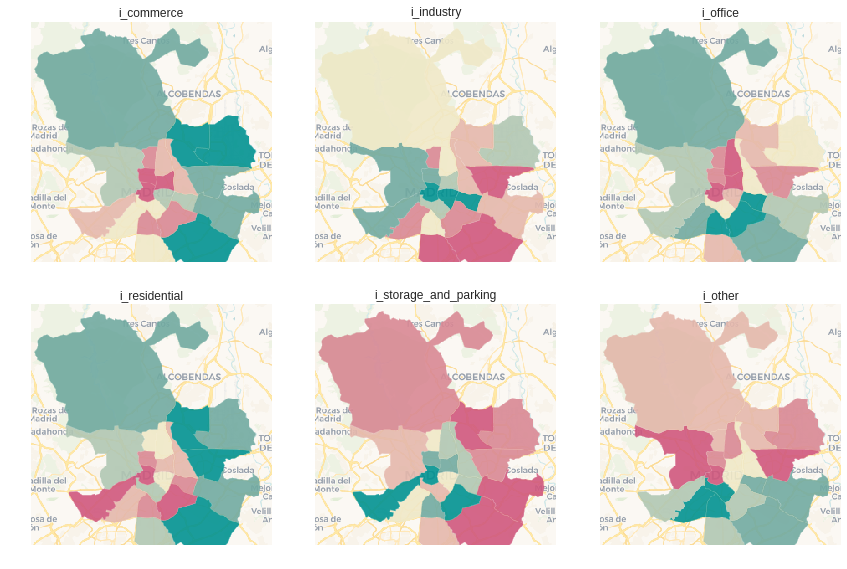

In [9]:
# subplotting every % use per neighborhood

from cartoframes import Layer, styling, BaseMap

fig, axs = plt.subplots(2, 3, figsize=(12, 8))

for idx, col in enumerate(cols_use):
    cc.map(layers=[BaseMap('voyager'), 
                   Layer(table,
                   color={'column': col[0],
                   'scheme': styling.scheme(col[1], 7, 'quantiles')})],
                    ax=axs[idx // 3][idx % 3],
                    zoom=10, lng=-3.6969, lat=40.4804,
                    interactive=False,
                    size=(288, 288))
    axs[idx // 3][idx % 3].set_title(col[0])
fig.tight_layout()
plt.show()

### Number of houses

In [0]:
# list of tupples with normalized number of houses/period per neighborhood and color palette

cols_num = [
    ('norm_before_1960', 'Sunset'),
    ('norm_60_69', 'Sunset'),
    ('norm_70_79', 'Sunset'),
    ('norm_80_89', 'Sunset'),
    ('norm_90_00', 'Sunset'),
    ('norm_00_10', 'Sunset')
]

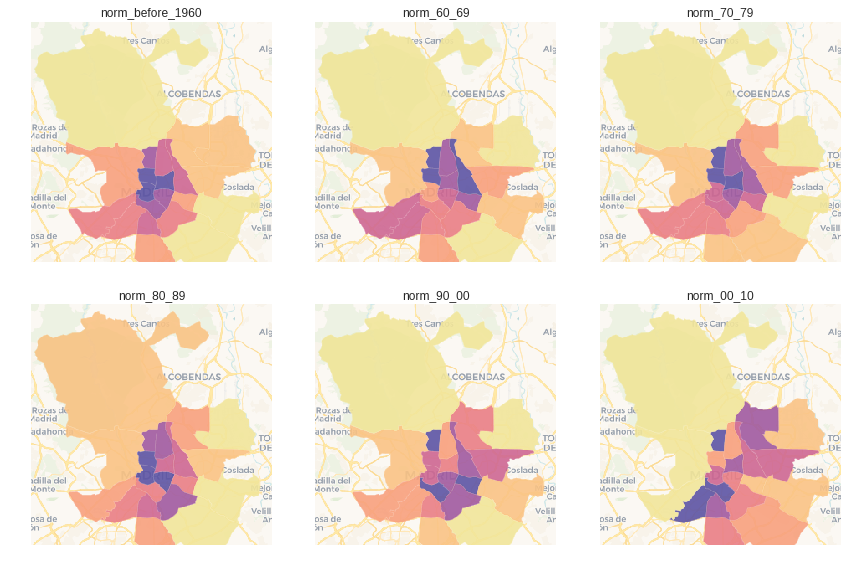

In [11]:
# subplotting evolution of normalized number of houses/period per neighborhood

fig, axs = plt.subplots(2, 3, figsize=(12, 8))

for idx, col in enumerate(cols_num):
    cc.map(layers=[BaseMap('voyager'), 
                   Layer(table,
                   color={'column': col[0],
                   'scheme': styling.scheme(col[1], 7, 'quantiles')})],
                    ax=axs[idx // 3][idx % 3],
                    interactive=False,
                    zoom=10, lng=-3.6969, lat=40.4804,
                    size=(288, 288))
    axs[idx // 3][idx % 3].set_title(col[0])
fig.tight_layout()
plt.show()

### Pivot table, animate it by date

In [12]:
# pivot table

pivot_madrid = cc.query(''' 
 with data as (
  select 
     to_timestamp(unnest(array['1950','1960','1970','1980','1990','2000']), 'YYYY') AS date,
     unnest(array[norm_before_1960,norm_60_69,norm_70_79,norm_80_89,norm_90_00,norm_00_10]) AS norm_num_houses,
     the_geom
   from 
    madrid_idea
) select 
    row_number() over () as cartodb_id,
    st_transform(the_geom, 3857) as the_geom_webmercator,
    *
    from data
''')

cc.write(pivot_madrid, 'pivot_mad_idea', overwrite=True)
pivot_madrid.head()

Table successfully written to CARTO: https://ramirocdb.carto.com/dataset/pivot_mad_idea


,date,norm_num_houses,the_geom
cartodb_id,,,
1,1950-01-01,38.175370,0106000020E61000000100000001030000000100000011...
2,1960-01-01,23.846689,0106000020E61000000100000001030000000100000011...
3,1970-01-01,37.826610,0106000020E61000000100000001030000000100000011...
4,1980-01-01,26.957849,0106000020E61000000100000001030000000100000011...
5,1990-01-01,22.763504,0106000020E61000000100000001030000000100000011...


In [0]:
from cartoframes.contrib import vector

In [14]:
# get max,min values
print(pivot_madrid['norm_num_houses'].max())
print(pivot_madrid['norm_num_houses'].min())

# get max,min date
print(pivot_madrid['date'].max())
print(pivot_madrid['date'].min())

141.5814291026238
0.07425328506390058
2000-01-01 00:00:00
1950-01-01 00:00:00


In [15]:
# mapping the evolution of the normalized number of houses per neighborhood

vector.vmap(
    [vector.Layer(
        'pivot_mad_idea',
        color='opacity(ramp(viewportQuantiles($norm_num_houses, 5), reverse(Emrld)), 0.7)',
        time="animation(linear($date,time('1950-01-01 00:00:00'),time('2000-01-01 00:00:00')),30,fade(6,0))>0",
        strokeWidth=0),
    ], cc
    )

### Trend - number of houses built

In [16]:
# applying Markov analysis to calculate trends and volatibility

madrid_trends = cc.query(''' 
  SELECT
  c.cartodb_id,
  c.the_geom,
  m.trend,
  m.trend_up,
  m.trend_down,
  m.volatility
FROM
  cdb_crankshaft.CDB_SpatialMarkovTrend(
    'SELECT * FROM madrid_idea',
    Array['before_1960', 'n_1960_1969',
    'n_1970_1979',
    'n_1980_1989',
    'n_1990_1999',
    'n_2000_2010']) As m
JOIN madrid_idea As c
ON c.cartodb_id = m.rowid''')

cc.write(madrid_trends, 'madrid_trends', overwrite=True)

Table successfully written to CARTO: https://ramirocdb.carto.com/dataset/madrid_trends


In [17]:
madrid_trends.head(10)

,the_geom,trend,trend_down,trend_up,volatility
cartodb_id,,,,,
1,0106000020E61000000100000001030000000100000013...,NaN,0.000000,1.00,0.349927
2,0106000020E61000000100000001030000000100000055...,NaN,1.000000,0.00,0.349927
3,0106000020E61000000100000001030000000100000021...,NaN,0.000000,1.00,0.349927
4,0106000020E61000000100000001030000000100000016...,0,0.000000,0.00,0.349927
5,0106000020E6100000010000000103000000010000002A...,-2,0.666667,0.00,0.164957
6,0106000020E6100000010000000103000000010000003F...,NaN,0.000000,1.00,0.349927
7,0106000020E61000000100000001030000000100000013...,NaN,0.000000,1.00,0.349927
8,0106000020E61000000100000001030000000100000010...,-2,0.666667,0.00,0.164957
9,0106000020E61000000100000001030000000100000014...,NaN,0.000000,1.00,0.242810


In [0]:
# create two datasets: up and down

madrid_up = cc.query('''
  SELECT * FROM madrid_trends WHERE trend_up <> 0.0
''')
madrid_down = cc.query('''
  SELECT * FROM madrid_trends WHERE trend_up = 0.0
''')

In [19]:
cc.write(madrid_up, 'madrid_up', overwrite=True)
cc.write(madrid_down, 'madrid_down', overwrite=True)

Table successfully written to CARTO: https://ramirocdb.carto.com/dataset/madrid_up
Table successfully written to CARTO: https://ramirocdb.carto.com/dataset/madrid_down


In [20]:
# mapping the trends of building construction per neighborhood

cc.map(layers=[BaseMap('voyager'), 
                   Layer('madrid_up',
                   color={'column': 'trend_up',
                   'scheme': styling.scheme('BluGrn', 3, 'quantiles')}),
                   Layer('madrid_down',
                   color={'column': 'trend_down',
                   'scheme': styling.scheme('Burg', 3, 'quantiles')})
              ])

### Trends - Number of houses built / area

In [21]:
# same analysis as above but normalizing the number of houses

madrid_trends_norm = cc.query(''' 
  SELECT
  c.cartodb_id,
  c.the_geom,
  m.trend,
  m.trend_up,
  m.trend_down,
  m.volatility
FROM
  cdb_crankshaft.CDB_SpatialMarkovTrend(
    'SELECT * FROM madrid_idea',
    Array['norm_before_1960',
    'norm_60_69',
    'norm_70_79',
    'norm_80_89',
    'norm_90_00',
    'norm_00_10']) As m
JOIN madrid_idea As c
ON c.cartodb_id = m.rowid''')

cc.write(madrid_trends_norm, 'madrid_trends_norm', overwrite=True)
madrid_trends_norm.head()

Table successfully written to CARTO: https://ramirocdb.carto.com/dataset/madrid_trends_norm


,the_geom,trend,trend_down,trend_up,volatility
cartodb_id,,,,,
1,0106000020E61000000100000001030000000100000013...,NaN,1.0,0.0,0.349927
2,0106000020E61000000100000001030000000100000055...,NaN,0.0,0.0,0.000000
3,0106000020E61000000100000001030000000100000021...,1,0.0,0.5,0.225877
4,0106000020E61000000100000001030000000100000016...,-0.5,0.4,0.2,0.139971
5,0106000020E6100000010000000103000000010000002A...,-1,0.5,0.0,0.225877


In [0]:
madrid_norm_up = cc.query('''
  SELECT * FROM madrid_trends_norm WHERE trend_up <> 0.0
''')
madrid_norm_down = cc.query('''
  SELECT * FROM madrid_trends_norm WHERE trend_up = 0.0
''')

In [23]:
cc.write(madrid_norm_up, 'madrid_norm_up', overwrite=True)
cc.write(madrid_norm_down, 'madrid_norm_down', overwrite=True)

Table successfully written to CARTO: https://ramirocdb.carto.com/dataset/madrid_norm_up
Table successfully written to CARTO: https://ramirocdb.carto.com/dataset/madrid_norm_down


In [24]:
cc.map(layers=[BaseMap('voyager'), 
                   Layer('madrid_norm_up',
                   color={'column': 'trend_up',
                   'scheme': styling.scheme('BluGrn', 3, 'quantiles')}),
                   Layer('madrid_norm_down',
                   color={'column': 'trend_down',
                   'scheme': styling.scheme('Burg', 3, 'quantiles')})
              ])

### Correlation Matrixes

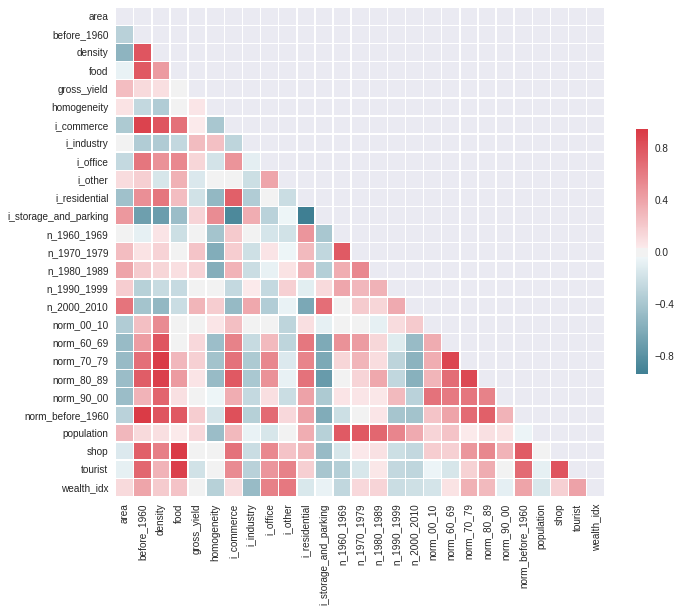

In [27]:
# Compute the correlation matrix
corr = madrid.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### Evolution by area

In [0]:
pivot_mad = cc.query(''' 
 with data as (
  select 
     to_timestamp(unnest(array['1950','1960','1970','1980','1990','2000']), 'YYYY') AS date,
     unnest(array[before_1960,n_1960_1969,n_1970_1979,n_1980_1989,n_1990_1999,n_2000_2010]) AS num_houses,
     locationname,
     the_geom
   from 
    madrid_idea
) select 
    row_number() over () as cartodb_id,
    st_transform(the_geom, 3857) as the_geom_webmercator,
    *
    from data
''')

In [51]:
areas = pivot_mad.locationname.unique().tolist()
areas

[u'Retiro',
 u'Arganzuela',
 u'Moratalaz',
 u'Vic\xe1lvaro',
 u'Tetu\xe1n',
 u'Salamanca',
 u'Villaverde',
 u'Villa de Vallecas',
 u'Ciudad Lineal',
 u'Centro',
 u'Moncloa',
 u'Carabanchel',
 u'Latina',
 u'Puente de Vallecas',
 u'Usera',
 u'Chamber\xed',
 u'Chamart\xedn',
 u'Barajas',
 u'Hortaleza',
 u'San Blas',
 u'Fuencarral']

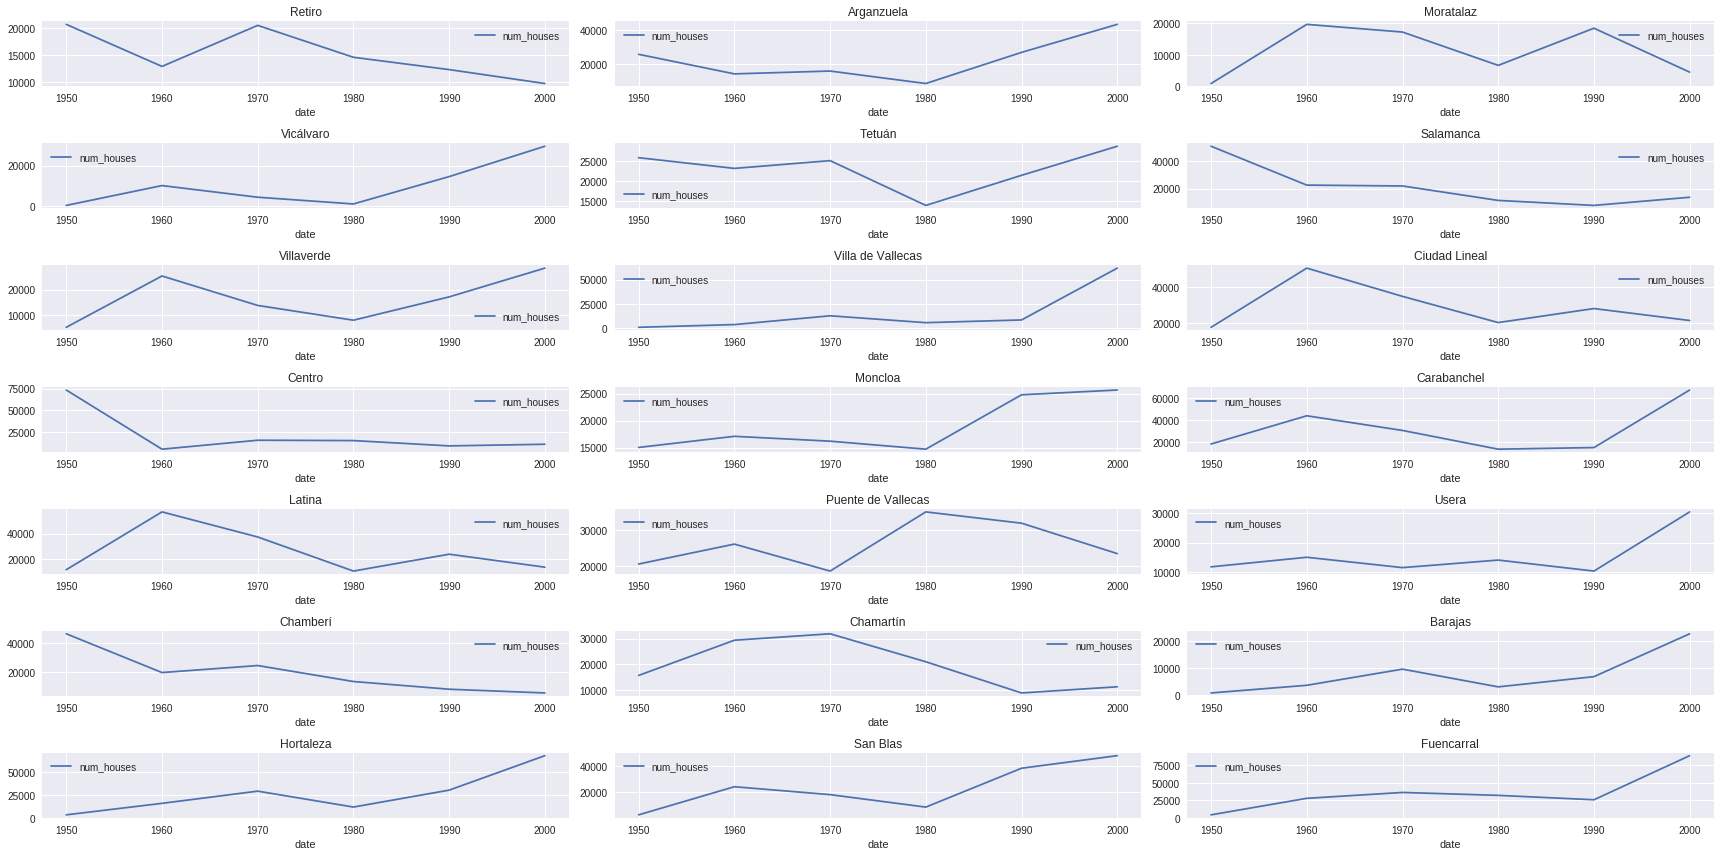

In [62]:
# subplotting the evolution of the number of houes per neighborhood

fig, axes = plt.subplots(7, 3, figsize=(24, 12))

for i in range(len(areas)):
  df = pivot_mad.loc[pivot_mad['locationname']==areas[i]]
  df[['date','num_houses']].set_index('date').plot(ax=axes[i//3][i%3])
  axes[i//3][i%3].set_title(areas[i])

fig.tight_layout()
plt.show()

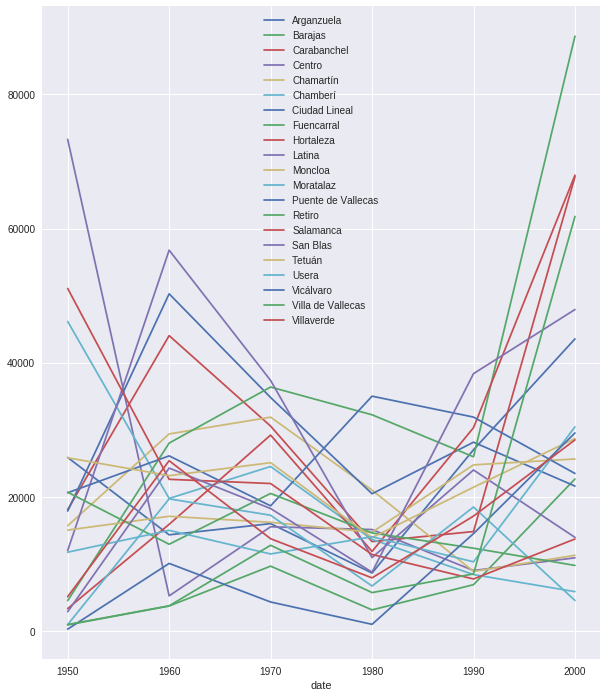

In [72]:
# plotting in the same graph the evolution

fig, ax = plt.subplots(figsize=(10,12))

for key, data in pivot_mad.groupby('locationname'):
    data.plot(x='date', y='num_houses', ax=ax, label=key)